In [1]:
import tensorflow as tf
import cv2
import numpy as np
import pandas as pd
import os
print("TensorFlow version:", tf.__version__)
print("OpenCV version:", cv2.__version__)

2025-04-09 00:13:55.126372: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-09 00:13:55.160469: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-09 00:13:55.324564: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-09 00:13:55.324654: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-09 00:13:55.340847: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

TensorFlow version: 2.15.0
OpenCV version: 4.9.0


### Cargar datasets y aplicar preprocesamiento

In [2]:
# === Configuración general ===
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
KERNEL_SIZE = 15

csv_path = "../dataset/HandInfo.csv"
image_root = "../dataset/image"

# === Leer CSV y procesar etiquetas ===
df = pd.read_csv(csv_path)

# Mapear aspectOfHand a etiquetas numéricas
class_names = sorted(df["aspectOfHand"].unique())
class_to_idx = {name: i for i, name in enumerate(class_names)}
df["label"] = df["aspectOfHand"].map(class_to_idx)

# === Z-score normalization ===
def z_score_normalization(image):
    mean = image.mean()
    std = image.std()
    return (image - mean) / std


# === Preprocesamiento personalizado con OpenCV ===
def preprocess_image(image_path):
    image_path = image_path.decode("utf-8")
    image = cv2.imread(image_path)

    if image is None:
        print(f"Error loading image: {image_path}")
        return np.zeros((*IMG_SIZE, 3), dtype=np.float32), -1  # Evitar errores

    image = cv2.resize(image, IMG_SIZE).astype(np.float32)
    low_freq_image = cv2.GaussianBlur(image, (KERNEL_SIZE, KERNEL_SIZE), 0)
    normalized_image = z_score_normalization(low_freq_image)

    return normalized_image


# === Función para cargar imágenes y etiquetas ===
def load_image(image_path):
    # Lee la imagen en formato JPG
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)  # Decodifica la imagen como RGB
    image = tf.image.resize(image, IMG_SIZE)  # Redimensiona la imagen
    image = tf.cast(image, tf.float32)  # Convierte a tipo float32
    return image


def tf_preprocess(image_path, label):
    # Cargar y preprocesar la imagen
    image = load_image(image_path)
    
    # Aplica el preprocesamiento de OpenCV
    image = tf.numpy_function(preprocess_image, [image_path], tf.float32)
    
    # Fijar el shape de la imagen
    image.set_shape((*IMG_SIZE, 3))
    label.set_shape(())  # Asegurar que el label tiene una forma escalar
    return image, label


# === Crear dataset para cada split (train, val, test) ===
def create_dataset_from_split(split_name):
    folder_path = os.path.join(image_root, split_name)

    # Archivos de imagen disponibles en la carpeta
    available_images = set(name for name in os.listdir(folder_path))

    # Imágenes del CSV en ese split
    df_split = df.copy()
    df_split["imageName"] = df_split["imageName"]

    # Filtrar solo las imágenes presentes en la carpeta
    split_df = df_split[df_split["imageName"].isin(available_images)]

    print(f"Nº ejemplos en split_df: {len(split_df)}")  # Dentro de create_dataset_from_split

    image_paths = [os.path.join(folder_path, name) for name in split_df["imageName"]]
    image_paths = tf.constant(image_paths)
    labels = tf.constant(split_df["label"].values)

    print(f"🧪 Nº imágenes: {len(image_paths)} | Nº etiquetas: {len(labels)}")

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(tf_preprocess, num_parallel_calls=tf.data.AUTOTUNE)

    if split_name == "train":
        dataset = dataset.shuffle(1000)

    
    return dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# === Crear datasets ===
train_ds = create_dataset_from_split("train")
print("Train dataset size:", len(train_ds))
val_ds = create_dataset_from_split("val")
print("Validation dataset size:", len(val_ds))
test_ds = create_dataset_from_split("test")
print("Test dataset size:", len(test_ds))

Nº ejemplos en split_df: 7753
🧪 Nº imágenes: 7753 | Nº etiquetas: 7753
Train dataset size: 243
Nº ejemplos en split_df: 1661
🧪 Nº imágenes: 1661 | Nº etiquetas: 1661
Validation dataset size: 52
Nº ejemplos en split_df: 1662
🧪 Nº imágenes: 1662 | Nº etiquetas: 1662
Test dataset size: 52


### Definición de la red tipo ResNet

In [3]:
from tensorflow.keras import layers, models

def residual_block(x, filters, downsample=False):
    identity = x
    stride = 2 if downsample else 1

    x = layers.Conv2D(filters, kernel_size=3, strides=stride, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    if downsample or identity.shape[-1] != filters:
        identity = layers.Conv2D(filters, kernel_size=1, strides=stride, use_bias=False)(identity)
        identity = layers.BatchNormalization()(identity)

    x = layers.Add()([x, identity])
    x = layers.ReLU()(x)
    return x

def build_resnet(input_shape=(224, 224, 3), num_classes=2):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, 7, strides=2, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    # 2 bloques
    for _ in range(2):
        x = residual_block(x, 64)

    # 3 bloques
    for i in range(3):
        x = residual_block(x, 128, downsample=(i==0))

    # 4 bloques
    for i in range(4):
        x = residual_block(x, 256, downsample=(i==0))

    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

### Compilación del modelo

In [ ]:
from tensorflow.keras.optimizers.legacy import SGD

initial_lr = 0.09
optimizer = SGD(learning_rate=initial_lr, momentum=0.9, decay=0.001)

NUM_CLASSES = len(class_to_idx)
model = build_resnet(num_classes=NUM_CLASSES)
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',  # o 'categorical_crossentropy' según tus etiquetas
    metrics=['accuracy']
)

/home/ale/Documentos/PID/genero_manos/venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Reducción de Learning Rate cada 8 épocas (30%)

In [5]:
def lr_scheduler(epoch, lr):
    if epoch > 0 and epoch % 8 == 0:
        return lr * 0.7
    return lr

lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

### Entrenamiento

Epoch 1/5
243/243 [==============================] - 355s 1s/step - loss: 1.2439 - accuracy: 0.6351 - val_loss: 15.1878 - val_accuracy: 0.2571 - lr: 0.0900
Epoch 2/5
243/243 [==============================] - 393s 2s/step - loss: 0.2694 - accuracy: 0.9066 - val_loss: 0.4910 - val_accuracy: 0.8236 - lr: 0.0900
Epoch 3/5
243/243 [==============================] - 353s 1s/step - loss: 0.1560 - accuracy: 0.9493 - val_loss: 0.4550 - val_accuracy: 0.8320 - lr: 0.0900
Epoch 4/5
243/243 [==============================] - 352s 1s/step - loss: 0.0931 - accuracy: 0.9708 - val_loss: 0.1416 - val_accuracy: 0.9567 - lr: 0.0900
Epoch 5/5
243/243 [==============================] - 353s 1s/step - loss: 0.0476 - accuracy: 0.9837 - val_loss: 0.2657 - val_accuracy: 0.9013 - lr: 0.0900


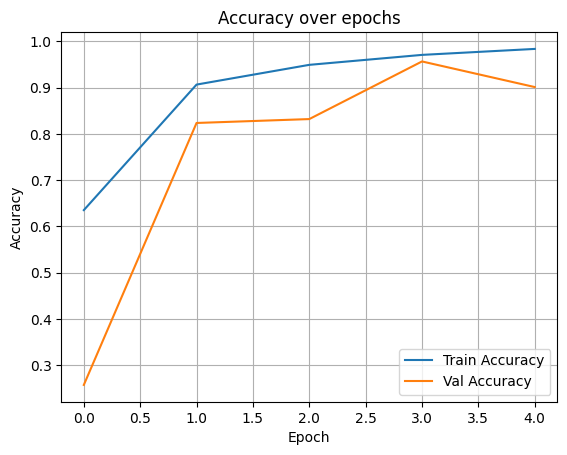

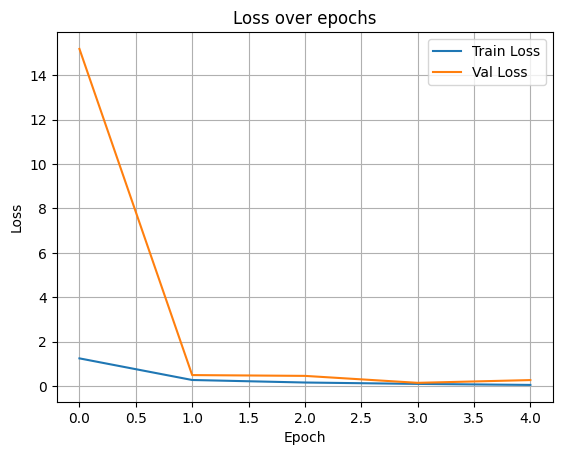

In [6]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,  # o el número que necesites
    callbacks=[lr_callback]
)

model.save("gaussian_model.h5")

import matplotlib.pyplot as plt

# Precisión
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Pérdida
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()